[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six
import yaml

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels, filled=False):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        image = draw_contours(image, masks[i], labels[i], filled)
    display_image(image)

def display_fluorescence(fluorescence, masks, labels):
    image = cv2.cvtColor(scale_image(fluorescence), cv2.COLOR_GRAY2RGB)
    if fluorescence.max() == 1:  # if binary image
        sc, fc = {}, {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            image = draw_contours(image, combined_mask & fluorescence, k, filled=True)
            sc[k] = sum(combined_mask.flatten())
            fc[k] = sum((combined_mask & fluorescence).flatten())
        for k in sc:
            print("Class %s (%s): %i/%i (%.2f%%)" %
                  (k, colormap.colors[k], fc[k], sc[k], fc[k]*100/sc[k]))
    else:
        fig, axs = plt.subplots(1, len(np.unique(labels)), figsize=(18,5))
        intensities = scale_image(image_fluorescent, 100)
        fc = {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            axs[k].hist(intensities.flatten()[np.nonzero(combined_mask.flatten())],
                     bins=range(100), color = colormap.colors[k])
            axs[k].set_title("Class %i" % k)
            axs[k].set_xlim([0,100])
    display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = TSNE(learning_rate='auto', init='pca', random_state=0).fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def draw_contours(image, mask, color_label, filled=False):
    color = np.array(matplotlib.colors.to_rgb(colormap.colors[color_label]))*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    thickness = -1 if filled else 1
    return cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=thickness)

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    # POSSIBLE BUG, VERIFY THAT from_dict DOESN'T INFER WRONG TYPES
    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, param_path, verbosity=0):
    with open(param_path, 'r') as f:
        param_file = yaml.load(f, Loader=yaml.FullLoader)
        mode = param_file['mode']
        params = param_file['params']

    if verbosity:
        print("Using mode '%s'." % mode)
    
    if verbosity and params.get('clipLimit'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    # We are also deliberately not sharpening here
    if params.get('canny_unmasking'):
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, 40, 180)
        canny_filled = apply_imfill(apply_closure(canny, 5))
        
    ### IMAGE PREPROCESSING ###
    
    if params.get('invert_image'):
        image = 255 - image

    if params.get('denoise_pre'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params.get('contrast'):
        if verbosity:
            print(("Enhancing contrast by factor of %.2f, with "
                   "offset=%s and preserve_background=%s.") %
                  (params['contrast'], params['offset'], params['preserve_background']))
        image = apply_contrast(image, params['contrast'],
                               params['offset'], params['preserve_background'])
    
    if params.get('clipLimit'):
        if verbosity:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params.get('denoise_post'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])

    if verbosity and params.get('clipLimit'):
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])
    
    ### IMAGE BINARIZATION ###
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbosity:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbosity:
            print("Applying Canny with thresholds %i and %i." %
                  (params['canny_thresh1'], params['canny_thresh2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['canny_thresh1'], params['canny_thresh2'])
    elif mode == "edge_sobel":
        if verbosity:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbosity:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbosity:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_manual":
        if verbosity:
            print("Manually thresholding on values >=%i." % params['manual_threshold'])
        binarized = np.uint8(image >= params['manual_threshold'])
    elif mode == "thresh_otsu":
        if verbosity:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None

    ### IMAGE POSTPROCESSING ###
    
    if params.get('size_thresh'):
        if verbosity:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params.get('canny_unmasking'):
        if verbosity:
            print("Unmasking areas without edges using Canny(40, 180):")
        binarized = binarized & canny_filled  # POSSIBLE BUG: CHECK IF CANNY_FILLED IS BINARY
        
    if params.get('closure_ks'):
        if verbosity:
            print("Closing with kernel size of %i." % params['closure_ks'])
        filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
        if verbosity >= 2:
            display_image_array([image, binarized, filled],
                                ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)
        return filled
    else:
        if verbosity >= 2:
            display_image_array([image, binarized],
                                ["Preprocessed", "Binarized"], columns=2, dpi=450)
        return binarized

# Extract mask from gray image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 100.00, with offset=-4 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking regions smaller than 25 pixels.
Closing with kernel size of 2.


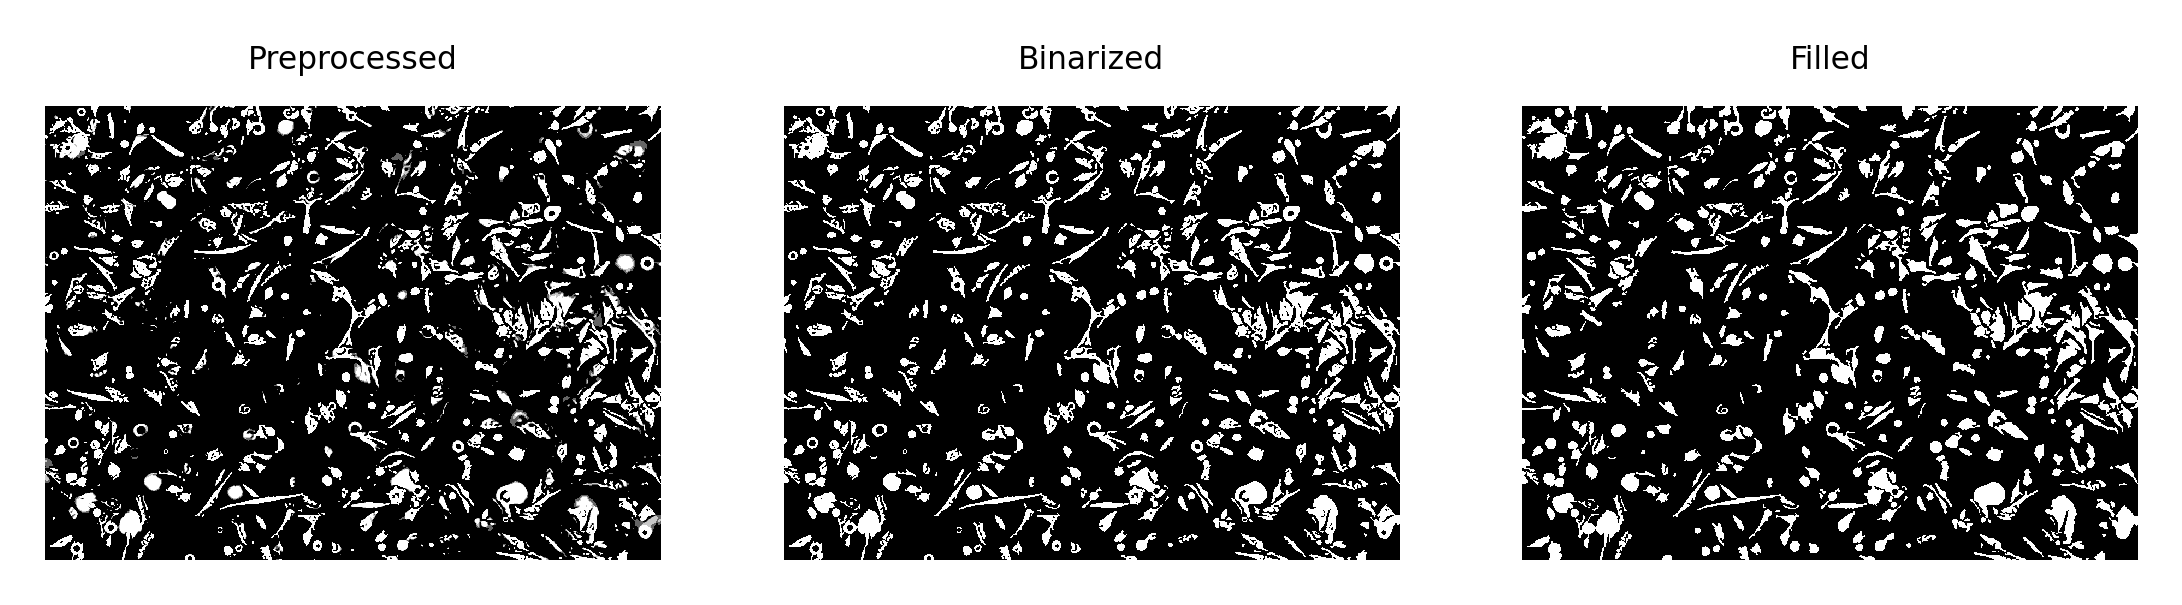

In [4]:
image_gray = cv2.imreadmulti('source_images/adherent_color.tiff',
                        flags=cv2.IMREAD_GRAYSCALE)[1][1]
image_gray = scale_image(image_gray)
mask_gray = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract mask from fluorescent image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 10.00, with offset=-3 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking regions smaller than 25 pixels.
Closing with kernel size of 2.


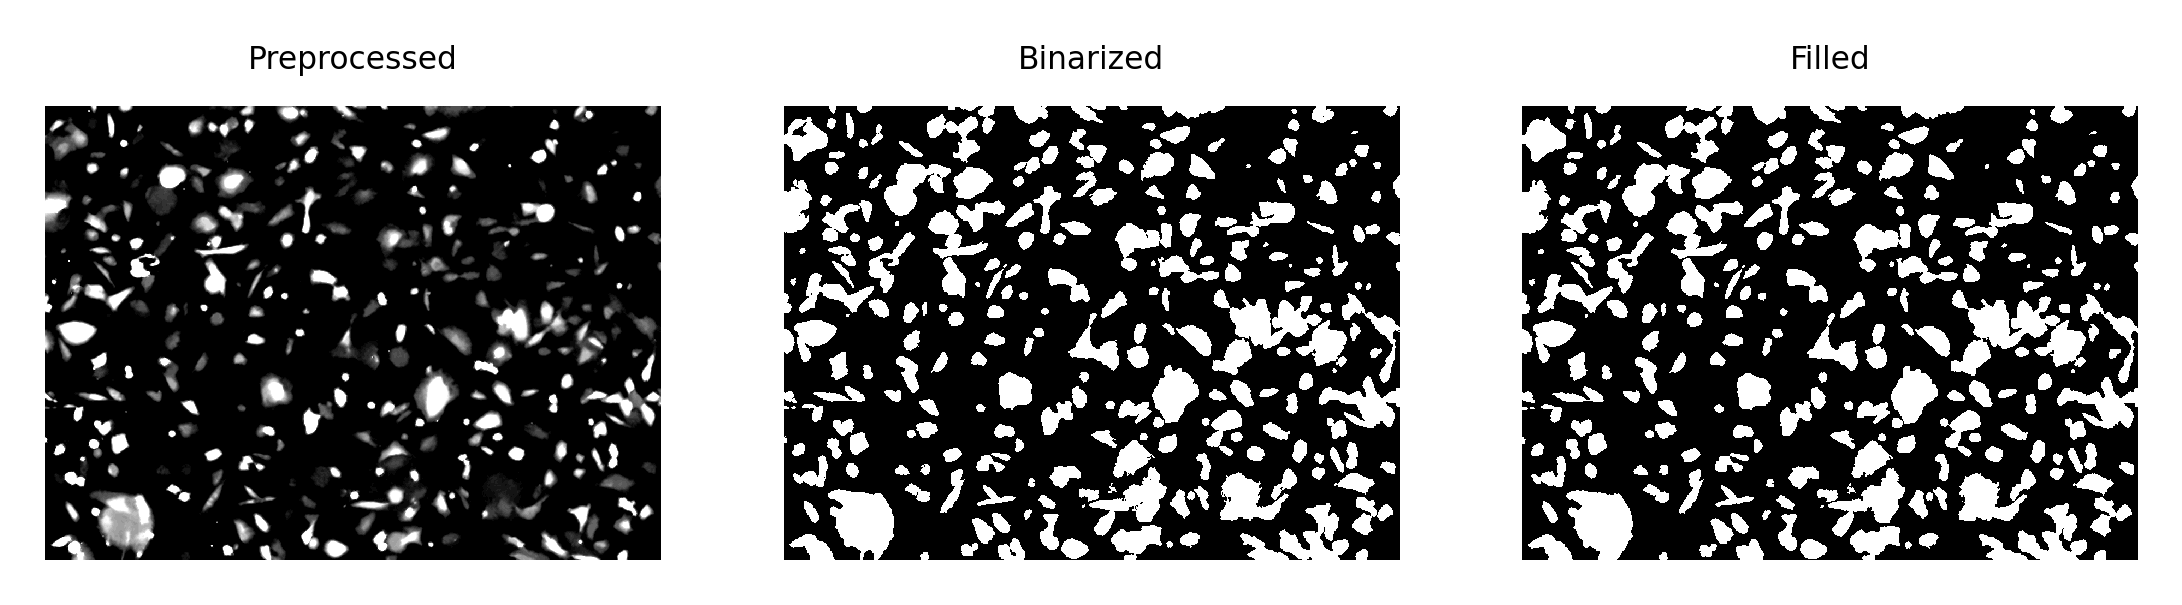

In [5]:
image_fluorescent = cv2.imreadmulti('source_images/adherent_color.tiff',
                                    flags=cv2.IMREAD_GRAYSCALE)[1][0]
image_fluorescent = scale_image(image_fluorescent)
mask_fluorescent = get_mask_image(image_fluorescent, 'params_fluorescent_mask.yml', verbosity=2)

# Merge masks, extract features, then scale and reduce dimensions

In [6]:
mask_image = mask_gray | mask_fluorescent
df, masks = extract_features(image_gray, mask_image)
display(df)

,,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
x,y,,,,,,,,,,,,,,,,,,,,,
91,6,0.657472,20.790206,22.847319317591726,188.5,13.668968,62.62741699796948,0.3322409389812705,189.0,0.777134,67.0,...,58.01587301587302,0.8712522045855379,12.735449735449736,32.00529100529101,322.0899470899471,3.8951043503821285,0.10958406819517931,0.11482310075705768,2.358357579608367,0.012257608549916692
147,5,0.483054,29.585444,29.614185789921695,318.5,14.291375,76.8700576850888,0.24135025960781412,319.0,0.823005,110.0,...,225.36990595611286,0.1589607020371262,4.636363636363637,57.407523510971785,248.0846394984326,14.38470916057123,0.2511320097526994,0.03229899669144332,0.1848689535317204,0.007390311297416525
316,48,0.792786,116.883253,115.67627241573788,4197.0,92.663362,733.068109219038,0.17466478656636597,4198.0,0.313278,100.0,...,2117.45497856122,0.45331643440091823,17.65269175797999,50.72987136731777,869.5750357313007,3.223856118991983,0.06573394333118351,0.03979311030783955,0.7417759432439184,0.003257281712463736
379,25,0.645207,65.373883,61.91122676865643,1470.0,42.179703,320.24978336205663,0.21785699548439227,1470.0,0.424399,100.0,...,780.5333333333333,0.5226623166273312,17.143537414965987,53.263945578231294,897.474149659864,3.859608843537415,0.07874867724867725,0.03301113422819367,0.5690429053266558,0.002902654138164882
452,21,0.721896,75.293996,77.93587107359485,2452.5,54.354459,278.4091629284905,0.11352055573027135,2453.0,0.630559,100.0,...,1302.403995108031,0.5091004816352565,17.53607827150428,57.423155320016306,983.8206278026906,3.6475163319846216,0.06723123982573054,0.03271205407696439,0.6033730823790614,0.0026571429543804873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,811,0.737119,48.363115,50.24937810560445,1336.5,35.649380,142.6101730552667,0.10670420729911463,1337.0,0.908738,114.0,...,693.1361256544502,0.288054894664206,11.18249813014211,56.58264771877337,613.6118175018698,5.752986578575584,0.10273310895038645,0.02661039178822863,0.3155334219548923,0.0027252197161213797
706,804,0.963029,12.766668,13.601470508735444,120.5,12.294676,43.45584412271569,0.3606294118067692,121.0,0.895468,70.0,...,32.768595041322314,1.4768116931903559,9.512396694214877,19.925619834710744,181.21487603305786,7.647263544536273,0.29621671258034893,0.08412972489271191,0.8247312878319372,0.017888710465820856
341,813,0.548395,40.487259,38.63935817272331,632.5,22.203002,121.49747468305844,0.192090869064124,633.0,0.733784,80.0,...,156.50710900473933,1.35873457968649,10.770932069510268,36.64296998420221,315.434439178515,7.066885679627301,0.1834294925184397,0.0682862603821003,1.038010024719618,0.00955485500191209


In [7]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df.to_numpy(dtype=np.float64))
reduced = pca.fit_transform(scaled)
df = pd.DataFrame(reduced, index=df.index)

display(df)

,,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
x,y,,,,,,,,,,,,,,,,,,,,,
91,6,-6.397527,-2.427458,-0.179198,-0.869287,-3.062209,0.254486,-0.504556,-0.626203,0.580707,-2.146571,...,-0.025813,-0.011146,0.005266,-0.014504,-0.004455,0.001696,-0.009969,0.001723,1.111916e-04,-0.000017
147,5,4.974360,-1.507625,-2.519914,0.119717,-0.582026,0.854659,-0.895551,-0.322575,-0.876312,0.143707,...,0.003719,0.009838,0.004038,0.009370,-0.007704,-0.004780,0.001720,-0.000914,-4.168557e-05,-0.000006
316,48,-0.899627,8.471090,-0.042012,-0.378296,-0.988053,-1.579825,0.473024,0.223777,-0.615378,-1.408036,...,0.011921,0.004838,-0.003179,-0.005933,-0.008169,0.002796,0.002408,-0.001190,1.886366e-05,0.000213
379,25,-0.046669,3.990981,-1.884952,2.495870,-1.013859,0.100278,-0.402879,-1.044829,-0.120848,0.734229,...,-0.020219,0.003244,-0.007922,-0.001467,-0.000795,-0.002074,-0.004720,-0.000980,-6.446436e-08,-0.000135
452,21,-0.177763,5.866926,-0.917778,1.992291,-0.411031,1.660810,0.347885,-0.894164,0.327076,-0.390165,...,-0.012793,0.000852,-0.003373,-0.001835,-0.006460,0.004472,0.000247,0.000625,7.213301e-06,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,811,3.026266,2.774933,-2.359960,1.946882,0.666850,1.708997,-2.329868,-1.320977,-1.473881,-0.002085,...,-0.000816,-0.003727,-0.004852,0.001976,0.007691,0.004347,0.002452,0.001368,3.373600e-05,-0.000018
706,804,-6.769276,-5.527517,0.683860,-0.741921,2.877713,-0.913617,-2.223145,-0.447581,-1.878533,1.509948,...,0.003532,0.001381,-0.003767,0.000140,-0.005529,-0.006746,-0.009477,-0.003051,5.101222e-05,-0.000002
341,813,-6.907551,-0.442739,-0.457028,1.770754,1.778141,-0.191353,2.421869,0.555827,0.814288,-0.049556,...,-0.017543,-0.004026,0.001108,0.011912,0.005382,-0.002092,0.004102,-0.003004,5.278512e-04,-0.000066


# Determine number of clusters

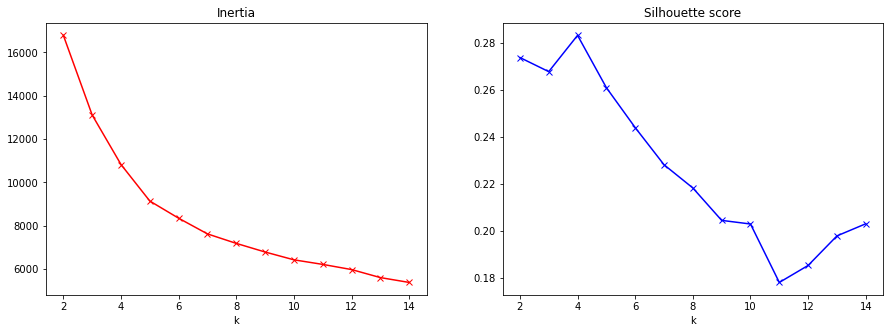

In [8]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

## User-defined values

In [9]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

# Fit and classify using k-means

In [10]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 24 (9.96%)
Class 1 (red): 61 (25.31%)
Class 2 (cyan): 105 (43.57%)
Class 3 (orange): 51 (21.16%)


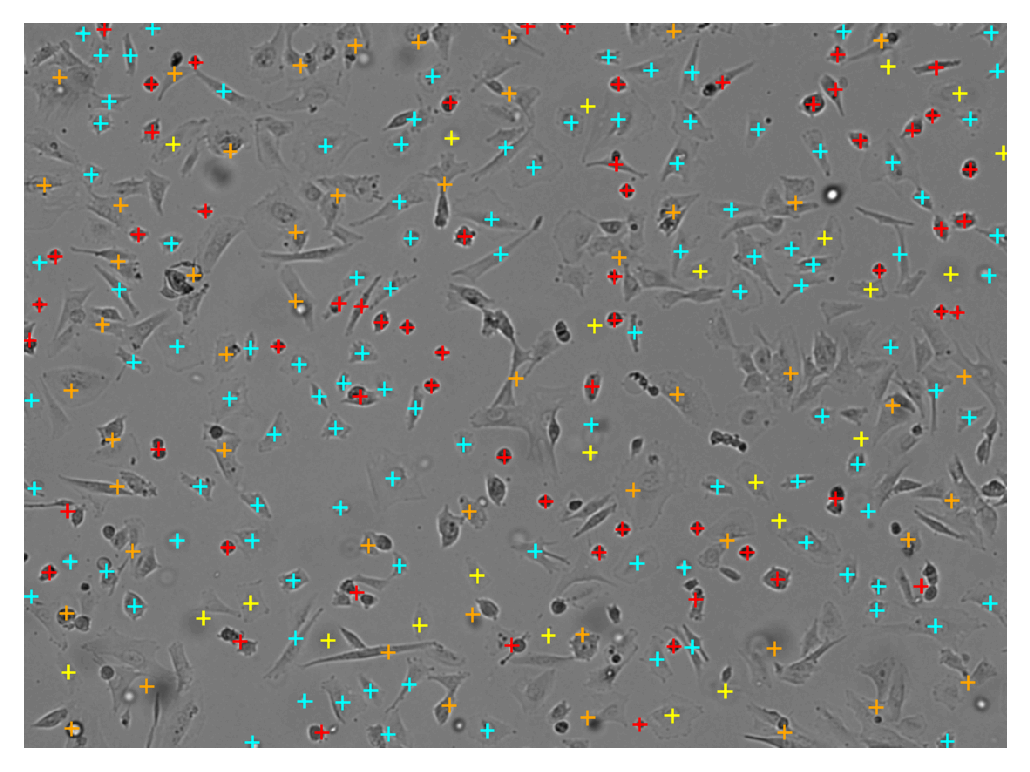

In [11]:
display_classifications(image_gray, df.index, labels)

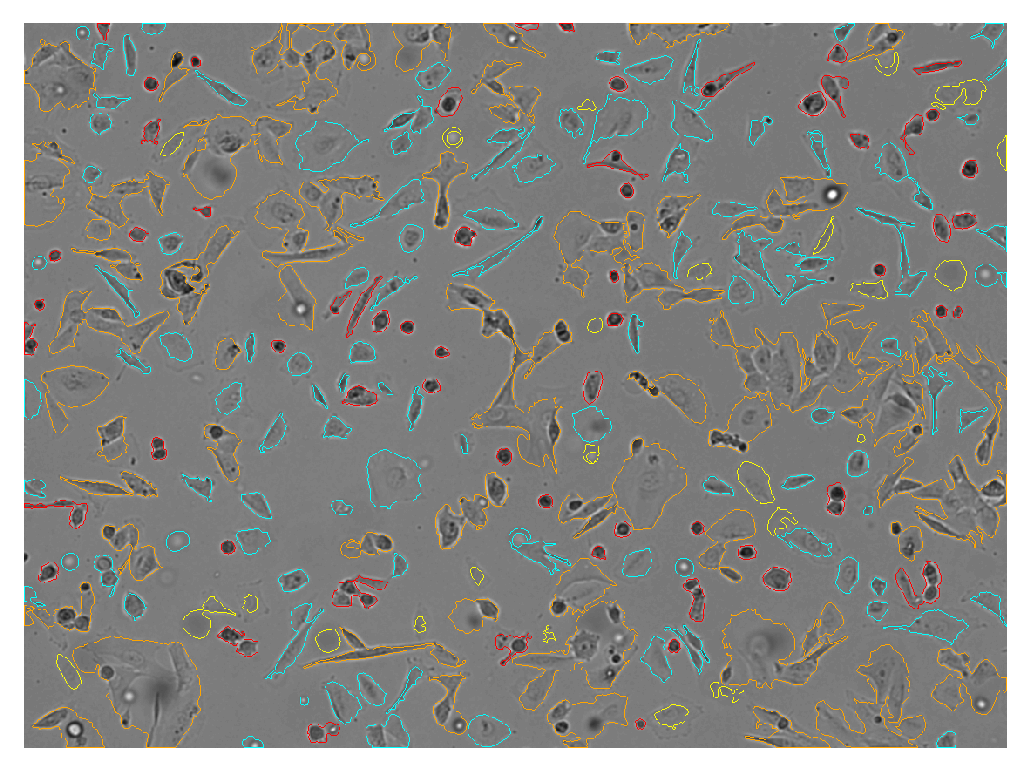

In [12]:
display_contours(image_gray, masks, labels)

Class 0, with 24 ROIs:


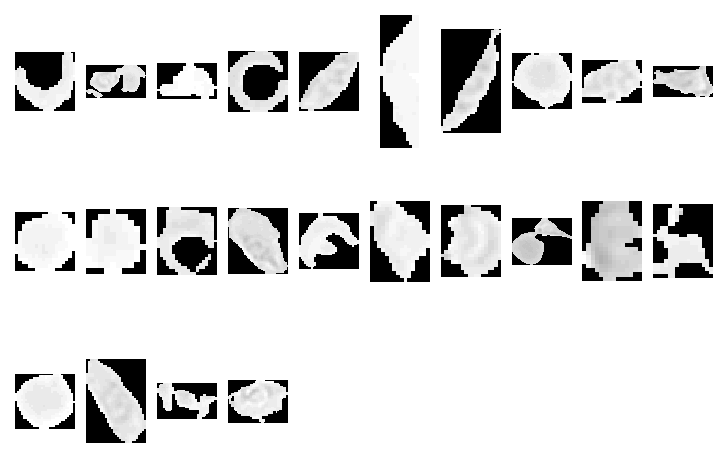

Class 1, with 61 ROIs:


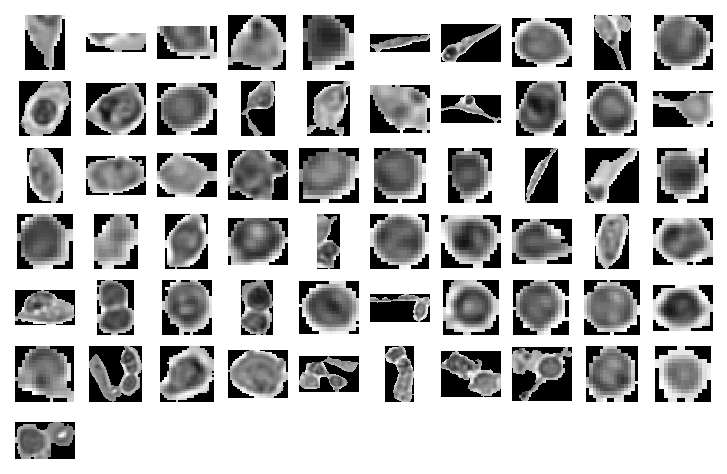

Class 2, with 105 ROIs:


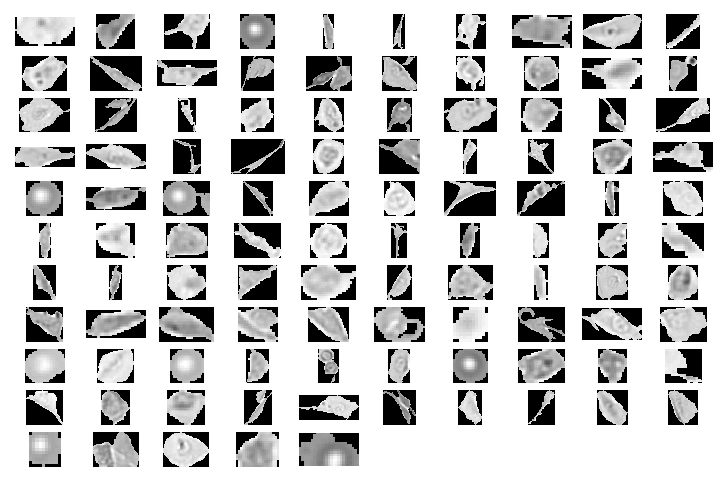

Class 3, with 51 ROIs:


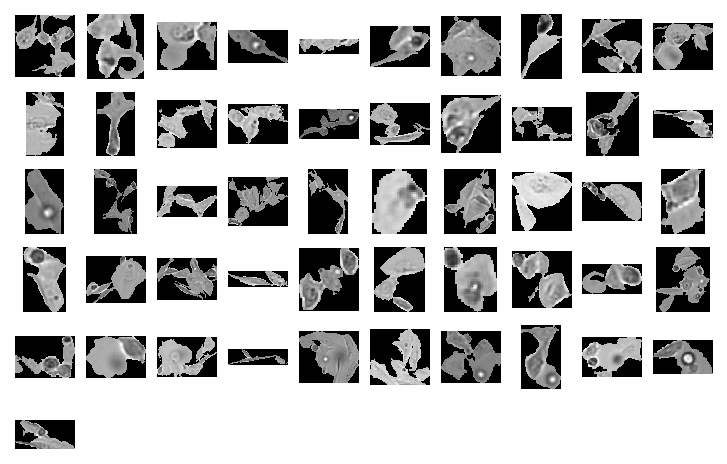

In [13]:
display_rois(image_gray, masks, labels)

# Visualize clusters with t-SNE

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


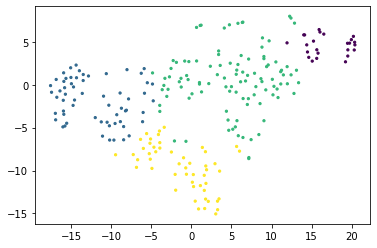

In [14]:
display_tsne(df)

# Quantify fluorescence within clusters

## Binary analysis

In [15]:
fluorescence_binarized = \
    get_mask_image(image_fluorescent, 'params_fluorescence.yml', verbosity=1)

Using mode 'thresh_manual'.
Denoising with intensity 2.
Enhancing contrast by factor of 10.00, with offset=-3 and preserve_background=False.
Manually thresholding on values >=1.


Class 0 (yellow): 4460/11857 (37.61%)
Class 1 (red): 18864/24417 (77.26%)
Class 2 (cyan): 52535/72407 (72.56%)
Class 3 (orange): 149353/186637 (80.02%)


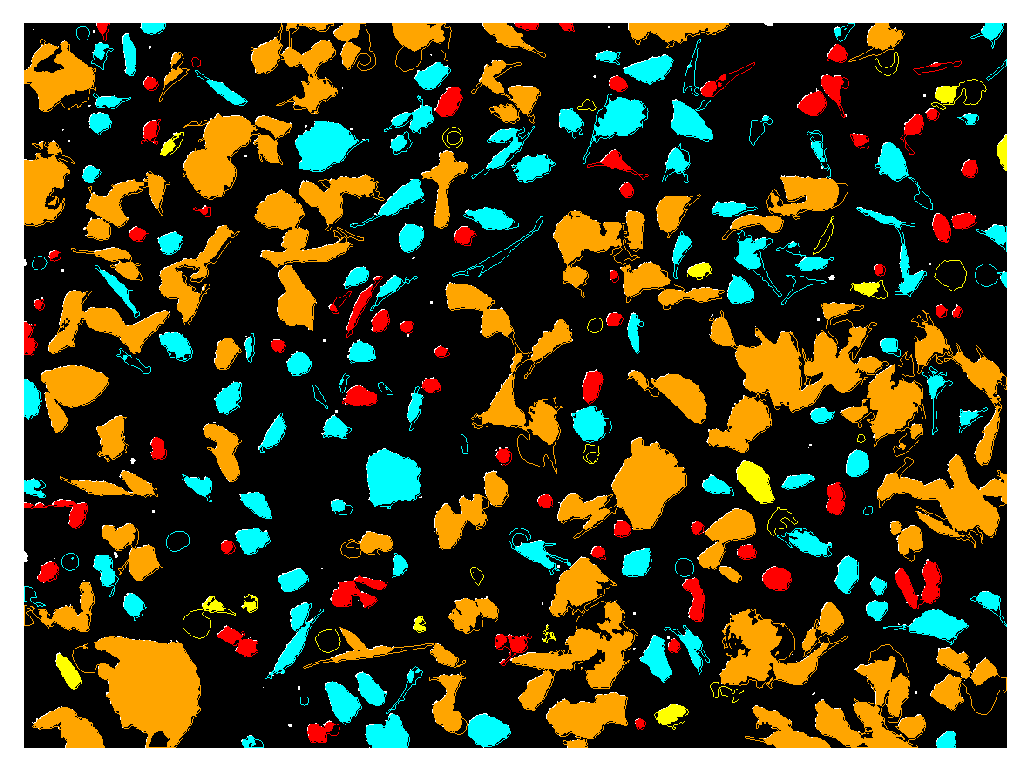

In [16]:
display_fluorescence(fluorescence_binarized, masks, labels)

## Intensity analysis

Class 0


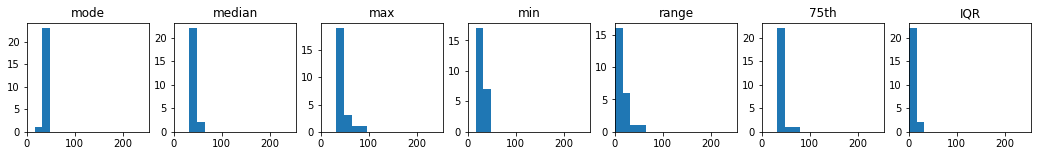

Class 1


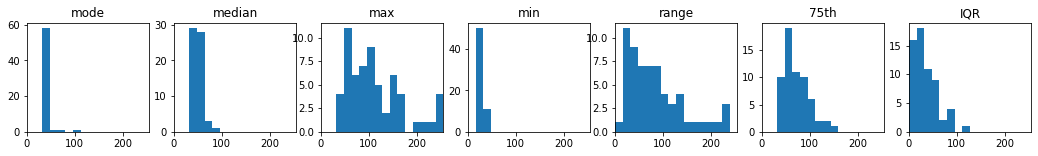

Class 2


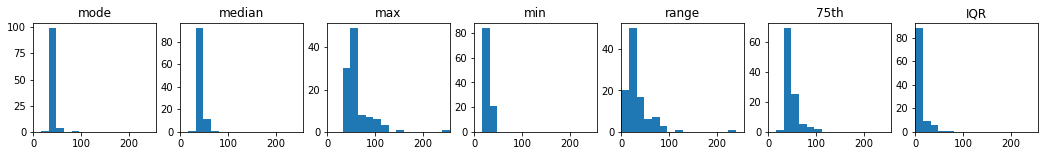

Class 3


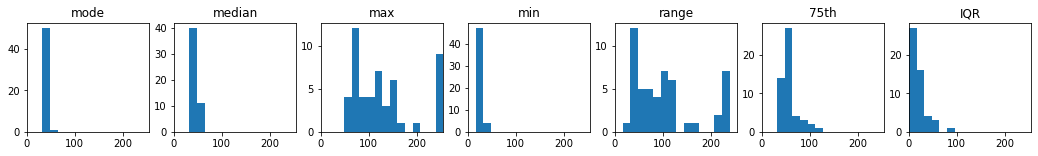

In [17]:
statistics = [[]] * len(np.unique(labels))

column_labels = ["mode", "median", "max", "min", "range", "75th", "IQR"]

for i in range(len(masks)):
    intensities = image_fluorescent.flatten()[np.argwhere(masks[i].flatten()).flatten()]
    s, c = np.unique(intensities, return_counts=True)
    # can't use += here, will cause wonky behavior
    statistics[labels[i]] = statistics[labels[i]] + \
                            [[s[np.argmax(c)],  # returns the first mode
                             np.median(intensities),
                             np.max(intensities),
                             np.min(intensities),
                             np.max(intensities) - np.min(intensities),
                             np.percentile(intensities, 75),
                             np.percentile(intensities, 75) - np.percentile(intensities, 25)],]
    
for i in range(len(statistics)):
    # must convert to numpy array before passing to pandas, or will infer wrong types
    statistics[i] = pd.DataFrame(np.array(statistics[i]),
                                 columns=column_labels)
    
    print("Class %i" % i)
    fig, axs = plt.subplots(1, len(column_labels), figsize=(18,2))
    for j in range(len(column_labels)):
        c = column_labels[j]
        axs[j].hist(statistics[i][c], bins=16, range=(0,256))
        axs[j].set_title(c)
        axs[j].set_xlim([0,256])
    plt.show()

## Kruskal-Wallis H test

In [18]:
for c in column_labels:
    print("%s:\tpvalue=%s" % (c, stats.kruskal(*[k[c].values for k in statistics])[1]))
    for i in range(len(statistics)):
        for j in range(i+1, len(statistics)):
            pval = stats.kruskal(statistics[i][c].values, statistics[j][c].values)[1]
            if pval >= 0.05:
                print("  %i,%i:\tpvalue=%.10f" % (i, j, pval))

mode:	pvalue=0.00010180085882100011
  0,1:	pvalue=0.2494423403
  2,3:	pvalue=0.8029308645
median:	pvalue=6.091779333304876e-14
max:	pvalue=6.224217781003309e-24
  1,3:	pvalue=0.0950665638
min:	pvalue=0.005567885884501324
  0,1:	pvalue=0.2974382636
  0,2:	pvalue=0.4779933782
  0,3:	pvalue=0.2918343157
  1,2:	pvalue=0.6202196503
range:	pvalue=7.998952934665637e-25
  1,3:	pvalue=0.0614556755
75th:	pvalue=2.0342287609912434e-18
IQR:	pvalue=2.598183499223297e-20


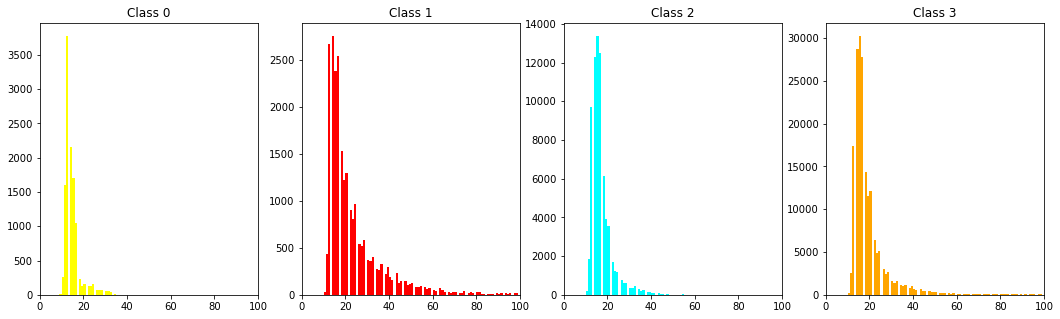

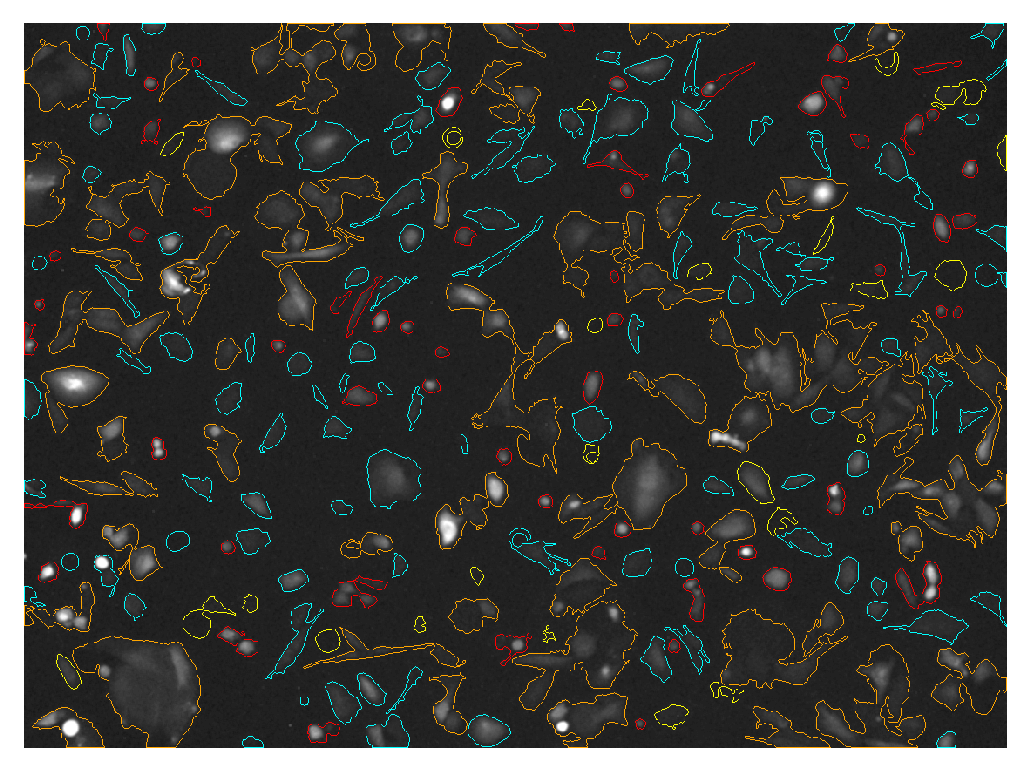

In [19]:
display_fluorescence(image_fluorescent, masks, labels)

# Experiment w/ multi-Otsu

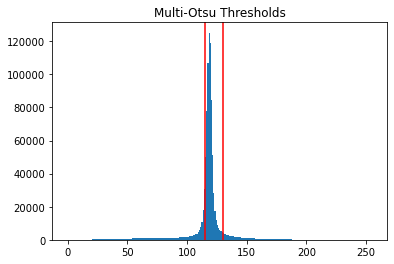

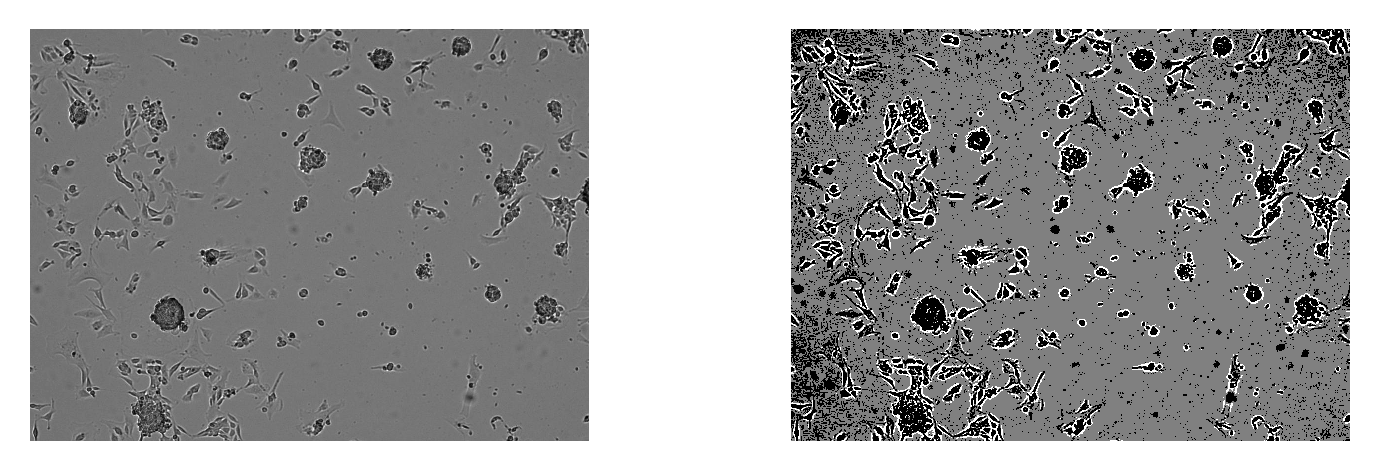

In [20]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
# blurred = apply_blur(raw_image, 5)
# enhanced = apply_contrast(blurred, 10)
# thresholds = threshold_multiotsu(enhanced)
histogram = np.histogram(raw_image.flatten(), bins=255)[0]
histogram[:97] = 0
histogram[161:] = 0
thresholds = threshold_multiotsu(hist=histogram)
multi_otsu_regions = np.digitize(raw_image, bins=thresholds)

plt.hist(raw_image.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, multi_otsu_regions], columns=2, dpi=300)